In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_09 import *

In [3]:
AvgStats

exp.nb_04.AvgStats

In [4]:
from fastai.vision.all import URLs,untar_data
path = untar_data(URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [5]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [6]:
nfs = [32]*10

In [7]:
#export
def param_getter(m): return m.parameters()

class Learner():
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2, splitter=param_getter,
                 cbs=None, cb_funcs=None):
        self.model,self.data,self.loss_func,self.opt_func,self.lr,self.splitter = model,data,loss_func,opt_func,lr,splitter
        self.in_train,self.logger,self.opt = False,print,None
        
        # NB: Things marked "NEW" are covered in lesson 12
        # NEW: avoid need for set_runner
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor([0.])
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')

    def fit(self, epochs, cbs=None, reset_opt=False):
        # NEW: pass callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # NEW: create optimizer on fit(), optionally replacing existing
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
            
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                if not self.do_begin_epoch(epoch): self.all_batches()

                with torch.no_grad(): 
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)

    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [8]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        #We use the logger function of the `Learner` here, it can be customized to write in a file or in a progress bar
        self.logger(self.train_stats)
        self.logger(self.valid_stats) 

In [9]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [42]:
sgd_opt

functools.partial(<class 'exp.nb_09.Optimizer'>, steppers=[<function weight_decay at 0x7f2953989840>, <function sgd_step at 0x7f29f7d89a60>])

In [10]:
#export
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [11]:
nfs = [32]*4
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)
len(list(learn.model.parameters()))

23

In [25]:
%time learn.fit(1)

train: [1.4539297436041292, tensor(0.5154, device='cuda:0')]
valid: [1.499268137937898, tensor(0.5019, device='cuda:0')]
CPU times: user 2.66 s, sys: 1.01 s, total: 3.68 s
Wall time: 5.87 s


In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

In [14]:
Hook

exp.nb_06.Hook

In [20]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if mod.training:
        if not hasattr(hook,'stats'): hook.stats = ([],[],[],[])
        means,stds, batch_mul,batch_add = hook.stats
        means.append(outp.data.mean())
        stds .append(outp.data.std())
        batch_mul.append(mod[-1].weight.mean())
        batch_add .append(mod[-1].bias.mean())

In [21]:
hooks = [Hook(l, append_stats) for l in children(learn.model[:-3])]

In [22]:
len(hooks)

7

In [23]:
plt.rcParams["figure.figsize"] = (20,10)

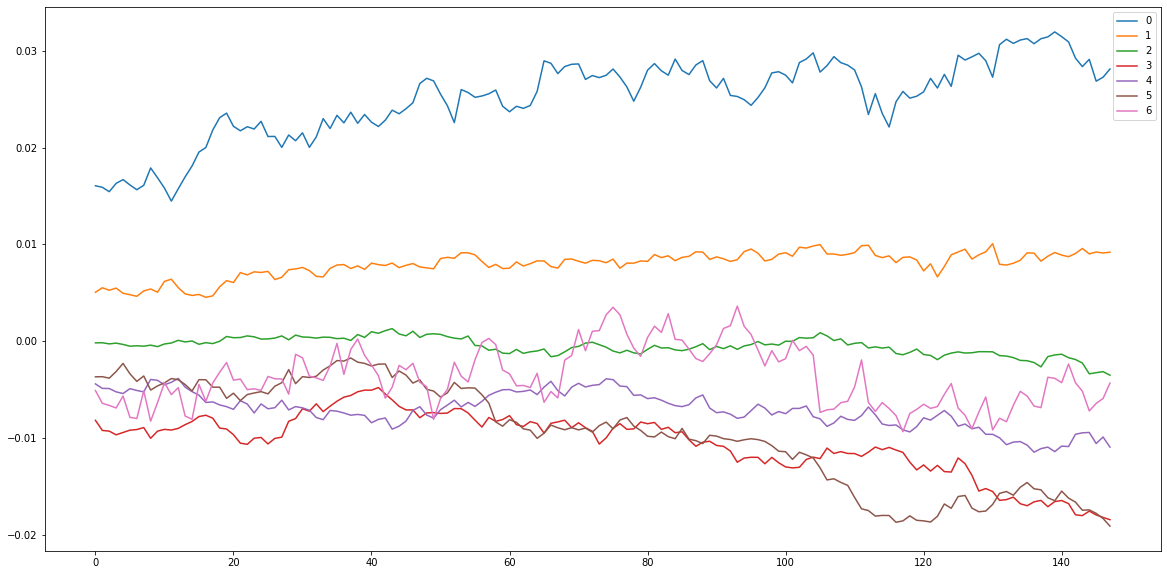

In [26]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(7));

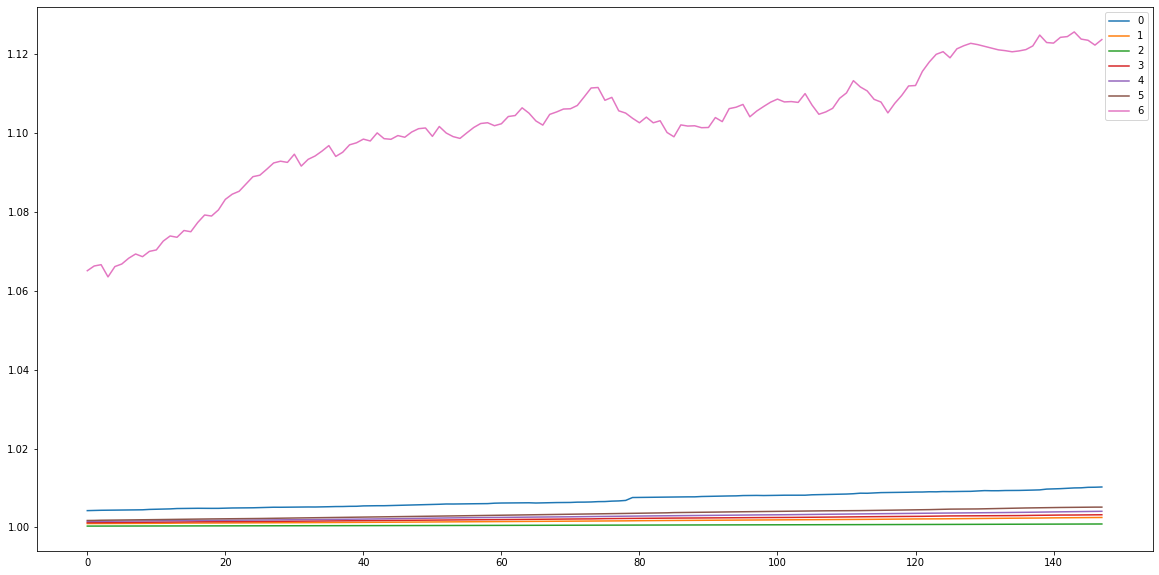

In [27]:
for h in hooks:
    plt.plot(h.stats[1])
    h.remove()
plt.legend(range(7));

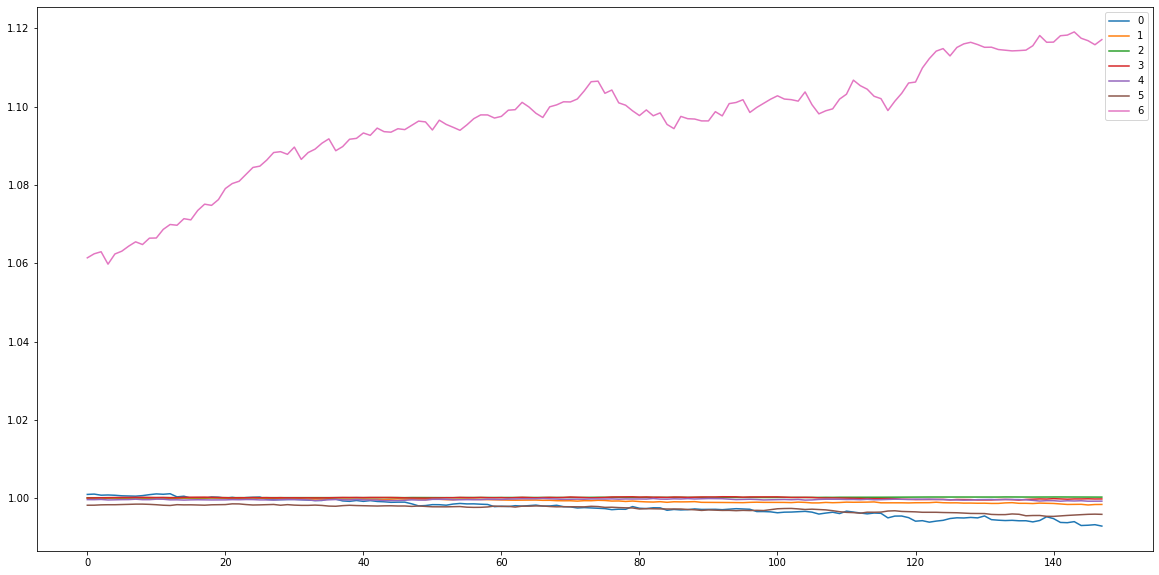

In [28]:
for h in hooks:
    plt.plot(h.stats[2])
    h.remove()
plt.legend(range(7));

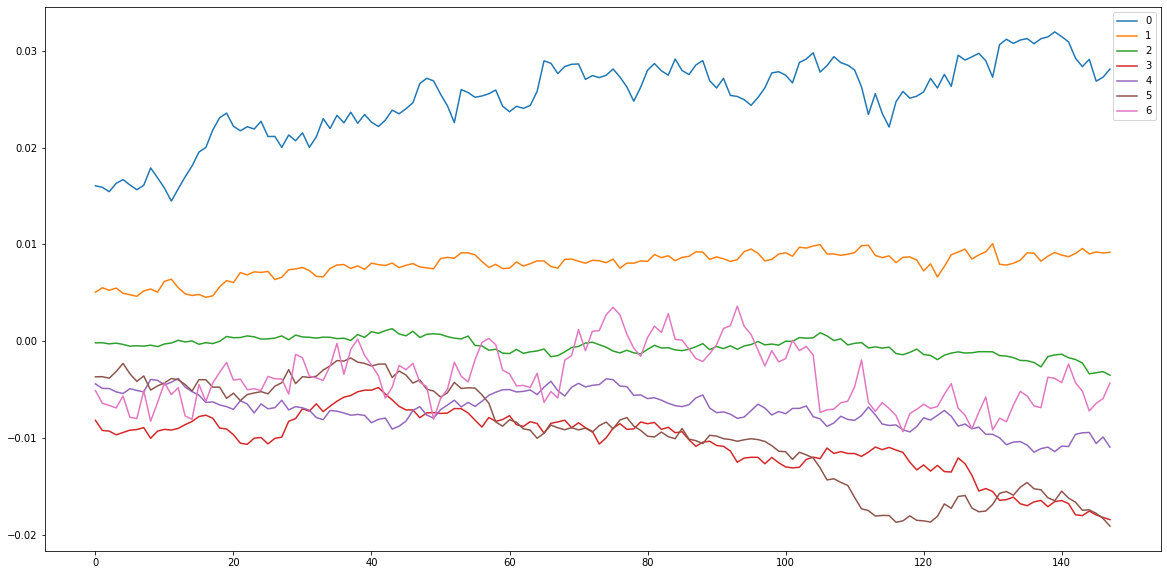

In [29]:
for h in hooks:
    plt.plot(h.stats[3])
    h.remove()
plt.legend(range(7));

In [30]:
len(hooks)

7

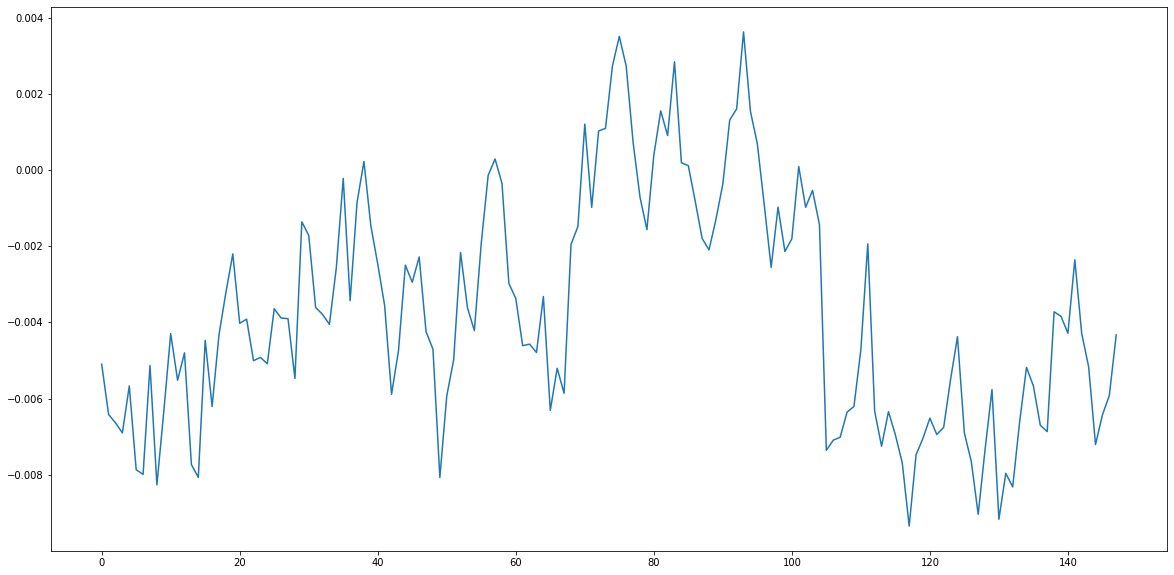

In [31]:
plt.plot(h.stats[-1])


In [32]:
learn.model[0]

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [33]:
learn.model[0][2].bias

Parameter containing:
tensor([ 0.0722, -0.0219, -0.1076,  0.2721, -0.2219,  0.0797, -0.0078, -0.0596,
        -0.0549, -0.0469,  0.0507,  0.2119,  0.1589,  0.0567,  0.0976, -0.0108],
       device='cuda:0', requires_grad=True)

In [34]:
from functools import partial 

In [35]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [36]:
cbfs += [Recorder]

In [37]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [38]:
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.2, 0.6, 0.2))
sched = ParamScheduler('lr', phases)

In [39]:
learn.fit(5, sched)

train: [1.8475465169236456, tensor(0.3465, device='cuda:0')]
valid: [1.8243130473726115, tensor(0.3824, device='cuda:0')]
train: [1.5130113107574716, tensor(0.4901, device='cuda:0')]
valid: [1.5252622412420382, tensor(0.4866, device='cuda:0')]
train: [1.2400247064433942, tensor(0.5890, device='cuda:0')]
valid: [1.2585857882165605, tensor(0.5822, device='cuda:0')]
train: [1.0294916924635653, tensor(0.6616, device='cuda:0')]
valid: [1.1242576880971338, tensor(0.6364, device='cuda:0')]
train: [0.8599059781424913, tensor(0.7192, device='cuda:0')]
valid: [1.0467826930732484, tensor(0.6639, device='cuda:0')]


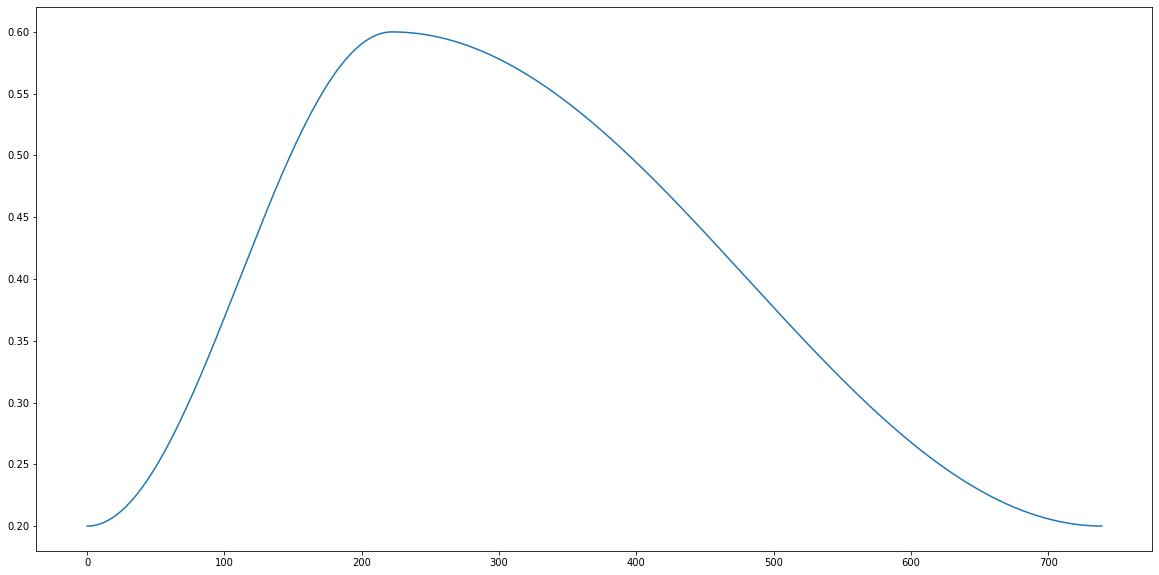

In [40]:
learn.recorder.plot_lr()

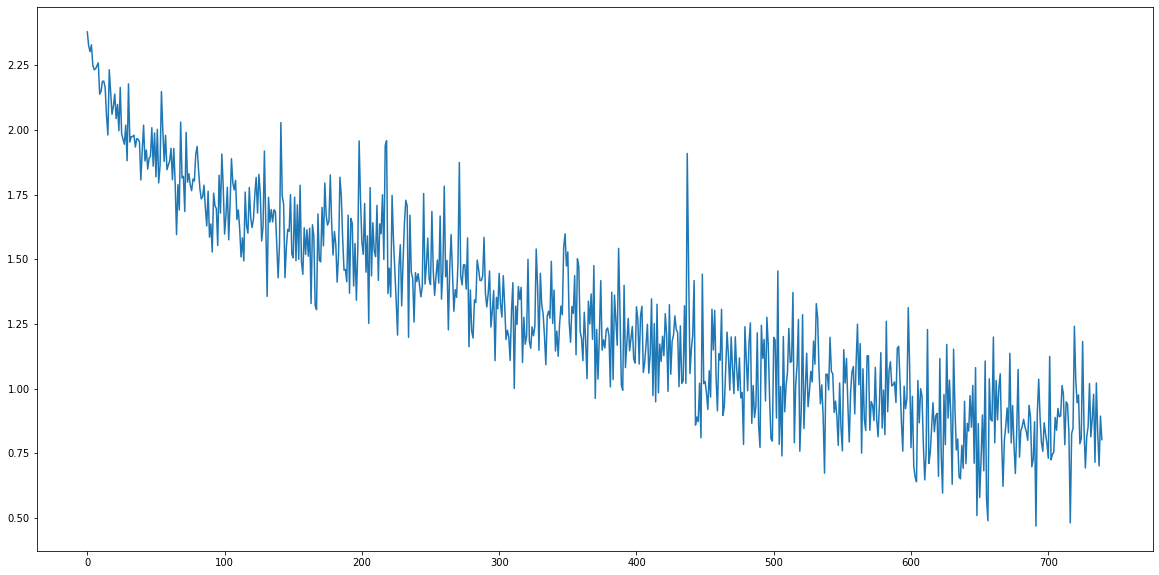

In [41]:
learn.recorder.plot_loss()

In [35]:
! python notebook2script.py 09b_learner.ipynb

Converted 09b_learner.ipynb to exp/nb_09b.py


In [1]:
class MyClass(object):

    def __init__(self):
        self.data = {'a': 'v1', 'b': 'v2'}
        self.c = 10

    def __getattr__(self, attr):
        return self.data[attr]

In [2]:
p = MyClass()

In [4]:
p.a

'v1'

In [8]:
def x(a=10,**kwargs):
    _res = 0
    for key in kwargs.keys():
        _res = _res + kwargs[key]
    return a + _res

In [10]:
x(1,one=2,two=5)

8